## AUTOMATED BEAD PATTERN GENERATION AND CUSTOMIZATION

Aim
This project aims to design and implement a user-centric intelligent system for automated bead pattern creation using machine learning (K-means Clustering and Rule-based symmetry algorithms).

Objective:
1. To acquire and preprocess the “Fashion Product Images (Small)”, focusing on key color and style information relevant to simple bead designs.
2. To implement a basic color-extraction process (such as k-means clustering) that derives user-friendly color palettes from both the Kaggle dataset and user-uploaded images.
3. To apply a rule-based method to generate initial bead layouts using the extracted color palettes, ensuring the suggestions are easily understandable and adaptable.
4. To design a web interface where users can preview and slightly modify recommended bead patterns, allowing immediate visual feedback.
5. To add a cost-estimation feature linking bead types and quantities to approximate prices, helping users assess financial feasibility with minimal effort.
6. To conduct a user test to gather feedback on design quality, cost accuracy, and usability, then make simple improvements based on the insights gained.

Importing necessary libraries

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

Importing the dataset

In [3]:
from google.colab import files
files.upload()  # upload kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"talabidamilare","key":"6f757ce7094ab037d011d041e41610ac"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Now download the dataset (replace the path with your dataset)
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

# Unzip it
!unzip fashion-product-images-small.zip -d fashion_images


Streaming output truncated to the last 5000 lines.
  inflating: fashion_images/myntradataset/images/5813.jpg  
  inflating: fashion_images/myntradataset/images/58131.jpg  
  inflating: fashion_images/myntradataset/images/58132.jpg  
  inflating: fashion_images/myntradataset/images/58133.jpg  
  inflating: fashion_images/myntradataset/images/58135.jpg  
  inflating: fashion_images/myntradataset/images/58136.jpg  
  inflating: fashion_images/myntradataset/images/58137.jpg  
  inflating: fashion_images/myntradataset/images/58138.jpg  
  inflating: fashion_images/myntradataset/images/58139.jpg  
  inflating: fashion_images/myntradataset/images/5814.jpg  
  inflating: fashion_images/myntradataset/images/58140.jpg  
  inflating: fashion_images/myntradataset/images/58141.jpg  
  inflating: fashion_images/myntradataset/images/58143.jpg  
  inflating: fashion_images/myntradataset/images/58144.jpg  
  inflating: fashion_images/myntradataset/images/58145.jpg  
  inflating: fashion_images/myntrada

Loading the dataset

In [5]:
dataset_path = "/content/fashion_images/images"

Number of images: 44441


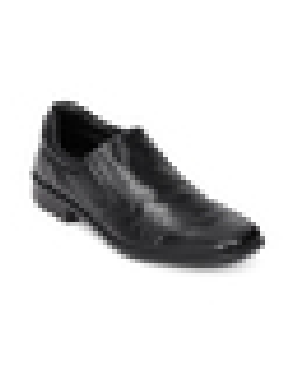

In [6]:
import os
from PIL import Image

# List image files
image_dir = 'fashion_images/images'
image_files = os.listdir(image_dir)
print("Number of images:", len(image_files))

# Show one sample image
sample_image = os.path.join(image_dir, image_files[8])
img = Image.open(sample_image)
plt.imshow(img)
plt.axis('off')
plt.show()


Kmeans Clustering for extracting dominant colors for  the pallete

In [7]:
import cv2
from sklearn.cluster import KMeans


# Set the image directory
image_dir = 'fashion_images/images'
image_files = os.listdir(image_dir)

In [8]:
# Preprocess image (resize + convert to RGB)
def preprocess_image_cv2(image_path, width=300, height=300):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    return image


In [9]:
# Extract k dominant colors
def extract_color_palette(image, k=5):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    palette = np.uint8(kmeans.cluster_centers_)
    _, counts = np.unique(kmeans.labels_, return_counts=True)
    sorted_idx = np.argsort(-counts)
    return palette[sorted_idx]

In [10]:
# Visualize the palette
def plot_palette(palette, title="Palette"):
    fig, ax = plt.subplots(figsize=(5, 1))
    for i, color in enumerate(palette):
        ax.fill_between([i, i+1], 0, 1, color=color/255)
    ax.set_xlim(0, len(palette))
    ax.set_title(title)
    ax.axis('off')
    plt.show()

Palette for image 23771.jpg:


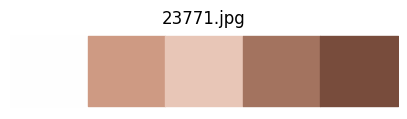

Palette for image 50484.jpg:


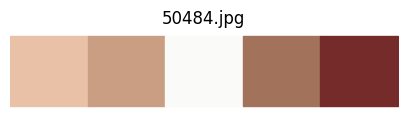

Palette for image 36916.jpg:


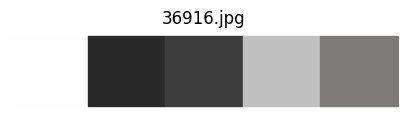

Palette for image 34006.jpg:


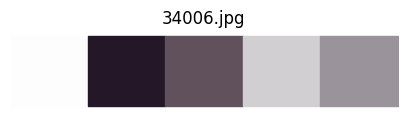

Palette for image 48527.jpg:


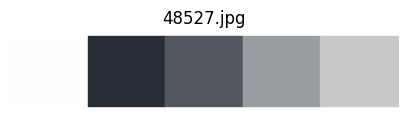

In [11]:
# Process first 5 images and display palettes
for idx, file in enumerate(image_files[:5]):
    image_path = os.path.join(image_dir, file)
    img = preprocess_image_cv2(image_path)
    if img is not None:
        palette = extract_color_palette(img, k=5)
        print(f"Palette for image {file}:")
        plot_palette(palette, title=file)


### Generate Bead Patterns from Palettes

#### 1D Linear Pattern Generators
(e.g., for bracelets, strings, rows)

Symmetric Linear Pattern

In [12]:
def generate_symmetric_pattern(palette, pattern_length=12):
    colors = [tuple(color) for color in palette]
    half = pattern_length // 2
    half_pattern = [colors[i % len(colors)] for i in range(half)]
    return half_pattern + half_pattern[::-1]


Alternating patterns

In [13]:
def generate_alternating_pattern(palette, pattern_length=12):
    colors = [tuple(color) for color in palette]
    pattern = []
    forward = True
    i = 0
    while len(pattern) < pattern_length:
        pattern.append(colors[i % len(colors)])
        i += 1 if forward else -1
        if i == len(colors) or i < 0:
            forward = not forward
            i = max(min(i, len(colors) - 1), 0)
    return pattern



Gradient Repeat Pattern


In [14]:
def generate_gradient_pattern(palette, pattern_length=12):
    colors = [tuple(color) for color in palette]
    return [colors[i % len(colors)] for i in range(pattern_length)]


Zigzag Mirror Pattern

In [15]:
def generate_zigzag_pattern(palette, pattern_length=12):
    colors = [tuple(color) for color in palette]
    pattern = []
    reverse = False
    while len(pattern) < pattern_length:
        sequence = colors[::-1] if reverse else colors
        for color in sequence:
            if len(pattern) >= pattern_length:
                break
            pattern.append(color)
        reverse = not reverse
    return pattern


Centered Burst Pattern

In [16]:
def generate_burst_pattern(palette, pattern_length=12):
    colors = [tuple(color) for color in palette]
    half = pattern_length // 2
    half_pattern = [colors[i % len(colors)] for i in range(half)]
    pattern = half_pattern[::-1] + half_pattern
    if pattern_length % 2 != 0:
        pattern.insert(half, colors[half % len(colors)])
    return pattern

#### 2D Grid-Based Pattern Generators
(e.g., necklace layouts, woven boards, earrings)

Vertical Symmetry Grid

In [17]:
def generate_vertical_symmetric_grid(palette, rows=8, cols=8):
    colors = [tuple(color) for color in palette]
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows):
        for j in range(cols // 2):
            color = colors[(i + j) % len(colors)]
            grid[i][j] = grid[i][cols - j - 1] = color
    return grid

Horizontal Symmetry Grid

In [18]:
def generate_horizontal_symmetric_grid(palette, rows=8, cols=8):
    colors = [tuple(color) for color in palette]
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows // 2):
        for j in range(cols):
            color = colors[(i + j) % len(colors)]
            grid[i][j] = grid[rows - i - 1][j] = color
    return grid

Radial Symmetry Grid

In [19]:
def generate_radial_symmetric_grid(palette, rows=8, cols=8):
    colors = [tuple(color) for color in palette]
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows // 2):
        for j in range(cols // 2):
            color = colors[(i + j) % len(colors)]
            grid[i][j] = grid[i][cols - j - 1] = grid[rows - i - 1][j] = grid[rows - i - 1][cols - j - 1] = color
    return grid

Random Pattern Grid

In [20]:
# 9. Random Pattern Grid
def generate_random_grid(palette, rows=8, cols=8, seed=42):
    rng = np.random.default_rng(seed)
    colors = [tuple(color) for color in palette]
    return [[colors[rng.integers(len(colors))] for _ in range(cols)] for _ in range(rows)]


plot grid

In [22]:
def plot_grid(grid, title="Bead Pattern"):
    rows, cols = len(grid), len(grid[0])
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    for i in range(rows):
        for j in range(cols):
            color = np.array(grid[i][j]) / 255
            circle = patches.Circle((j + 0.5, rows - i - 0.5), 0.45, color=color)
            ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    plt.show()

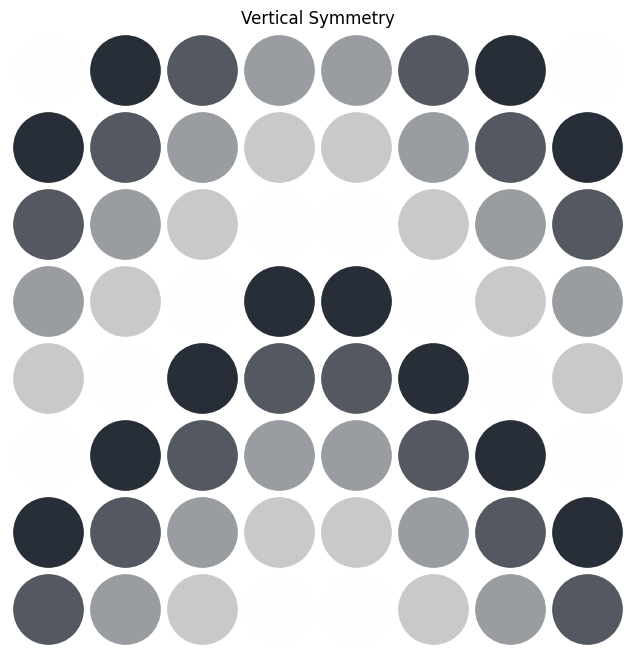

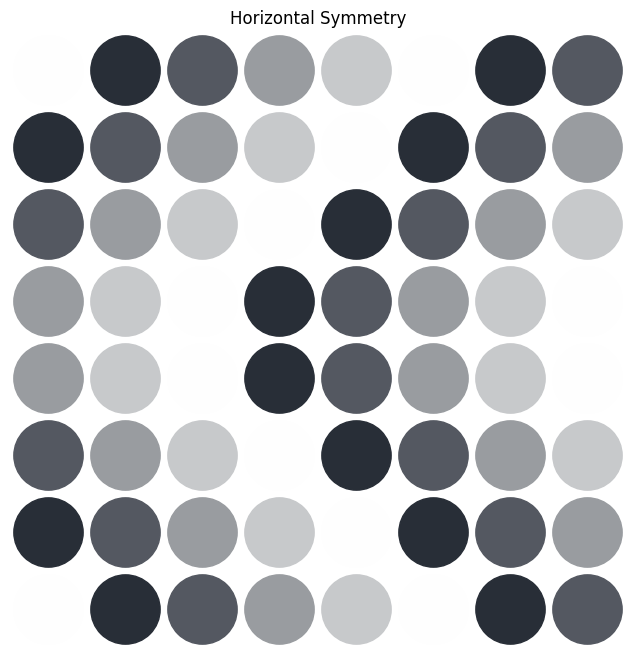

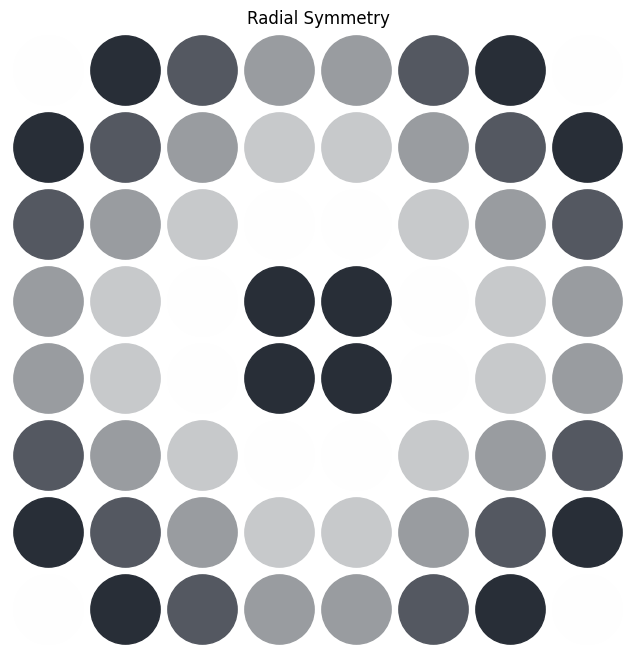

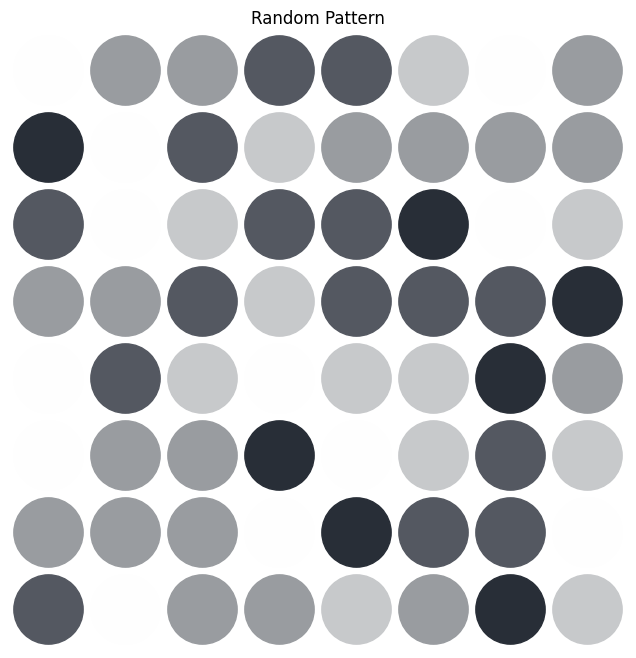

In [23]:
# Generate and plot each pattern
plot_grid(generate_vertical_symmetric_grid(palette), "Vertical Symmetry")
plot_grid(generate_horizontal_symmetric_grid(palette), "Horizontal Symmetry")
plot_grid(generate_radial_symmetric_grid(palette), "Radial Symmetry")
plot_grid(generate_random_grid(palette), "Random Pattern")


Adding a cost estimate for the the bead patterns

In [24]:
def estimate_total_cost(pattern, bead_cost=0.05):
    """
    Estimates the total cost of a bead pattern.

    Parameters:
        pattern (list or 2D grid): List of colors (1D or 2D pattern).
        bead_cost (float): Cost per bead in dollars.

    Returns:
        float: Total estimated cost.
    """
    if isinstance(pattern[0], list):  # 2D grid
        total_beads = sum(len(row) for row in pattern)
    else:  # 1D pattern
        total_beads = len(pattern)

    return round(total_beads * bead_cost, 2)


Creating a user interface

In [25]:
code_content = '''
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from PIL import Image

# ------------------------ CONFIG ------------------------
BEAD_COST_DEFAULT = 0.05

# ------------------------ CUSTOM STYLING ------------------------
st.markdown("""
    <style>
        .main {
            background-color: #F9F9F9;
        }
        h1, h2, h3 {
            color: #3F51B5;
        }
        .stButton>button {
            background-color: #FF7043;
            color: white;
            border-radius: 8px;
        }
    </style>
""", unsafe_allow_html=True)

# ------------------------ HELPERS ------------------------
def extract_color_palette(image, k=5):
    pixels = image.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)
    palette = np.uint8(kmeans.cluster_centers_)
    _, counts = np.unique(kmeans.labels_, return_counts=True)
    sorted_idx = np.argsort(-counts)
    return [tuple(color) for color in palette[sorted_idx]]

# ------------------------ PATTERN GENERATORS ------------------------
def generate_vertical_symmetric_grid(palette, rows=8, cols=8):
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows):
        for j in range(cols // 2):
            color = palette[(i + j) % len(palette)]
            grid[i][j] = grid[i][cols - j - 1] = color
    return grid

def generate_horizontal_symmetric_grid(palette, rows=8, cols=8):
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows // 2):
        for j in range(cols):
            color = palette[(i + j) % len(palette)]
            grid[i][j] = grid[rows - i - 1][j] = color
    return grid

def generate_radial_symmetric_grid(palette, rows=8, cols=8):
    grid = [[None]*cols for _ in range(rows)]
    for i in range(rows // 2):
        for j in range(cols // 2):
            color = palette[(i + j) % len(palette)]
            grid[i][j] = grid[i][cols - j - 1] = grid[rows - i - 1][j] = grid[rows - i - 1][cols - j - 1] = color
    return grid

def generate_random_grid(palette, rows=8, cols=8, seed=42):
    rng = np.random.default_rng(seed)
    return [[palette[rng.integers(len(palette))] for _ in range(cols)] for _ in range(rows)]

def generate_linear_pattern(palette, pattern_length=12, mode="symmetric"):
    colors = [tuple(color) for color in palette]
    if mode == "symmetric":
        half = pattern_length // 2
        pattern = [colors[i % len(colors)] for i in range(half)]
        return pattern + pattern[::-1]
    elif mode == "alternating":
        pattern, forward, i = [], True, 0
        while len(pattern) < pattern_length:
            pattern.append(colors[i % len(colors)])
            i += 1 if forward else -1
            if i == len(colors) or i < 0:
                forward = not forward
                i = max(min(i, len(colors)-1), 0)
        return pattern
    elif mode == "gradient":
        return [colors[i % len(colors)] for i in range(pattern_length)]
    elif mode == "zigzag":
        pattern, reverse = [], False
        while len(pattern) < pattern_length:
            seq = colors[::-1] if reverse else colors
            for color in seq:
                if len(pattern) >= pattern_length:
                    break
                pattern.append(color)
            reverse = not reverse
        return pattern
    elif mode == "burst":
        half = pattern_length // 2
        half_pattern = [colors[i % len(colors)] for i in range(half)]
        pattern = half_pattern[::-1] + half_pattern
        if pattern_length % 2 != 0:
            pattern.insert(half, colors[half % len(colors)])
        return pattern
    return []

# ------------------------ VISUALIZATION ------------------------
def plot_grid(grid, title="Bead Pattern"):
    rows, cols = len(grid), len(grid[0])
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    for i in range(rows):
        for j in range(cols):
            color = np.array(grid[i][j]) / 255
            circle = patches.Circle((j + 0.5, rows - i - 0.5), 0.45, color=color)
            ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    return fig

def plot_linear_pattern(pattern, title="1D Pattern"):
    fig, ax = plt.subplots(figsize=(len(pattern), 2))
    for i, color in enumerate(pattern):
        circle = patches.Circle((i + 0.5, 0.5), 0.45, color=np.array(color)/255)
        ax.add_patch(circle)
    ax.set_xlim(0, len(pattern))
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title)
    return fig

# ------------------------ COST ESTIMATION ------------------------
def estimate_total_cost(pattern, bead_cost=0.05):
    if isinstance(pattern[0], list):
        total_beads = sum(len(row) for row in pattern)
    else:
        total_beads = len(pattern)
    return round(total_beads * bead_cost, 2)

# ------------------------ STREAMLIT APP ------------------------
st.title("🎨 Bead Pattern Generator")

uploaded_file = st.file_uploader("Upload an image to generate a bead pattern:", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    image = np.array(image)
    palette = extract_color_palette(image, k=5)

    # Display image and palette
    st.image(image, caption="Uploaded Image", use_column_width=True)
    st.subheader("Extracted Color Palette")
    fig_palette = plt.figure(figsize=(5, 1))
    ax = fig_palette.add_subplot(111)
    for i, color in enumerate(palette):
        ax.fill_between([i, i+1], 0, 1, color=np.array(color)/255)
    ax.set_xlim(0, len(palette))
    ax.axis('off')
    st.pyplot(fig_palette)

    # Pattern Settings
    st.subheader("Pattern Settings")
    pattern_type = st.selectbox("Pattern Type", ["2D Pattern", "1D String Pattern"])
    symmetry_type = st.selectbox("Symmetry Type", ["Vertical", "Horizontal", "Radial", "Random"])
    pattern_style = st.selectbox("1D Pattern Style", ["symmetric", "alternating", "gradient", "zigzag", "burst"])
    rows = st.slider("Rows (for 2D)", 4, 20, 8)
    cols = st.slider("Columns (for 2D / Length for 1D)", 4, 20, 8)
    bead_cost = st.number_input("Bead Cost ($)", min_value=0.01, max_value=1.00, value=BEAD_COST_DEFAULT)

    # Generate pattern
    if pattern_type == "2D Pattern":
        if symmetry_type == "Vertical":
            grid = generate_vertical_symmetric_grid(palette, rows, cols)
        elif symmetry_type == "Horizontal":
            grid = generate_horizontal_symmetric_grid(palette, rows, cols)
        elif symmetry_type == "Radial":
            grid = generate_radial_symmetric_grid(palette, rows, cols)
        else:
            grid = generate_random_grid(palette, rows, cols)
        pattern = grid
        fig = plot_grid(grid, title=f"{symmetry_type} Symmetry Pattern")
    else:
        pattern = generate_linear_pattern(palette, pattern_length=cols, mode=pattern_style)
        fig = plot_linear_pattern(pattern, title=f"1D {pattern_style.capitalize()} Pattern")

    # Show pattern and cost
    st.subheader("Generated Bead Pattern")
    st.pyplot(fig)
    total_cost = estimate_total_cost(pattern, bead_cost)
    st.subheader("Estimated Cost")
    st.write(f"💰 This pattern would cost approximately **${total_cost}**")
else:
    st.warning("📸 Please upload an image to get started.")
'''

In [26]:
# Open a file in write mode and save the code content
with open('BeadPatternGeneraton.py', 'w') as file:
    file.write(code_content)

print("The Python script has been successfully saved to 'BeadPatternGeneraton.py'")


The Python script has been successfully saved to 'BeadPatternGeneraton.py'
